In [1]:
import talib
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style('grade3')
%matplotlib inline

Talib source code(C) : https://sourceforge.net/p/ta-lib/code/HEAD/tree/trunk/ta-lib/c/src/ta_func/

# 임시 데이터 불러오기

In [2]:
import pandas_datareader.data as web

from datetime import datetime

f = web.DataReader('F', 'robinhood')

f.head()

close_price high_price  interpolated  low_price open_price  \
symbol begins_at                                                               
F      2017-08-25   10.149700  10.205900         False  10.093400  10.102800   
       2017-08-28   10.121500  10.205900         False  10.065200  10.187200   
       2017-08-29   10.168400  10.215300         False  10.065200  10.084000   
       2017-08-30   10.262200  10.262200         False  10.102800  10.149700   
       2017-08-31   10.346600  10.506100         False  10.271600  10.290400   

                  session    volume  
symbol begins_at                     
F      2017-08-25     reg  35926827  
       2017-08-28     reg  22307395  
       2017-08-29     reg  29807261  
       2017-08-30     reg  23629293  
       2017-08-31     reg  54208921

In [3]:
opn = f['open_price']['F'].astype(float)
close = f['close_price']['F'].astype(float)
volume = f['volume']['F'].astype(float)
high = f['high_price']['F'].astype(float)
low = f['low_price']['F'].astype(float)

#### perform_test(my_series, ta_series) 직접 만든 함수와 TALIB 함수의 차이를 비교하기 위한 함수 <br>
#### column index 가 같다면 DataFrame 도 입력 가능합니다

In [8]:
def perform_test(my_series, ta_series):
    plt.figure(figsize=(12,7))
    plt.title('Comparison to Ta-Lib')
    plt.plot(ta_series, label = 'TA-Lib Result')
    plt.plot(my_series, label = 'My Result')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,7))
    plt.title('Difference')
    plt.plot(my_series - ta_series, label = 'Difference between them')
    plt.legend()
    plt.show()
    #test_df = pd.concat([series, ta_ema, ema], axis=1)
    #test_df

# 거래량

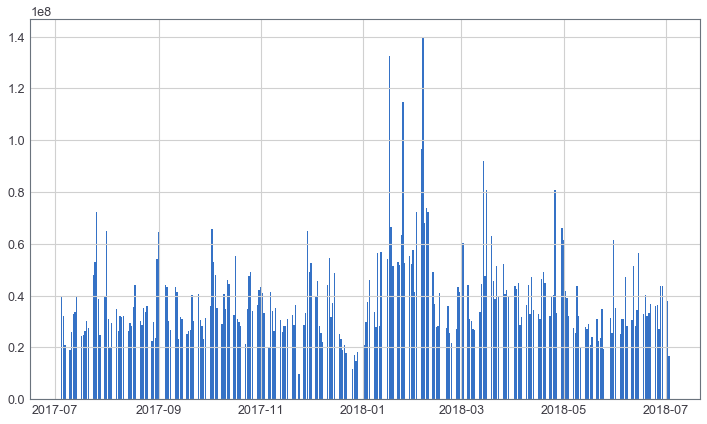

In [9]:
plt.figure(figsize=(12,7))
plt.bar(volume.index, volume)
plt.show()

# 지표 설명 : MACD 

MACD (Moving Average Convergence Divergence) <br>
이동평균 수렴발산

MACD는 이동평균수렴발산(Moving Average Convergence Divergence)의 약자인데, 이름에서 알 수 있듯이 이동평균이 서로 만나는(수렴, Convergence) 현상과 멀어지는(발산, 괴리, Divergence) 현상을 이용하였다. 여기서 주의해야 할 것은, MACD에서 사용되는 이동평균은 단순이동평균이 아니라 지수이동평균(EMA, Exponential Moving Average)이라는 점이다. 제럴드 아펠(Gerald Appel)이 1970년대 후반에 개발하였다.

MACD를 산출하는 공식은 다음과 같다.

MACD = 12일간 지수이동평균 - 26일간 지수이동평균 <br>
signal = MACD의 9일간 지수이동평균 <br>
MACD Hist: MACD Line - Signal Line <br>

### Parameters : fastperiod(단기)=12, slowperiod(장기)=26, signalperiod(신호)=9

*Note : 자신만의 특별한 노하우가 없다면 굳이 산출기간을 변경하는 것은 바람직하지 않다.* 

### 매매 방법 
*macd 가 signal 상향 돌파 -> 매수* <br>
*macd 가 signal 하향 돌파 -> 매도*

### Talib MACD

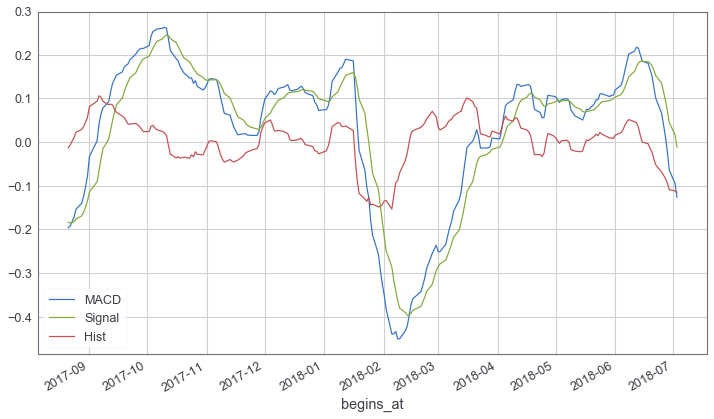

In [17]:
macd, macdsignal, macdhist = talib.MACD(np.array(close, dtype='f8'))
macd = pd.Series(macd, index=close.index, name='MACD')
macdsignal = pd.Series(macdsignal, index=close.index, name='Signal')
macdhist = pd.Series(macdhist, index=close.index, name='Hist')
ta_macd = pd.concat([macd, macdsignal, macdhist], axis=1)
ta_macd.plot(figsize=(12,7))
plt.show()

### 직접만든 MACD

In [16]:
def MACD(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd = EMA(close, fastperiod) - EMA(close, slowperiod)
    macdsignal = EMA(macd, signalperiod)
    macdhist = macd - macdsignal
    df = pd.concat([macd, macdsignal, macdhist],axis=1)
    df.columns = ['MACD','Signal','Hist']
    return df

In [242]:
def EMA(close, timeperiod=30):  # Exponential Moving Average : 지수이동평균
    k = 2/(1+timeperiod) # k : smoothing constant
    close = close.dropna()
    ema = pd.Series(index=close.index)
    ema[timeperiod-1] = close.iloc[0:timeperiod].sum() / timeperiod
    for i in range(timeperiod,len(close)):
        ema[i] = close[i]*k + ema[i-1] * (1-k)
    return ema

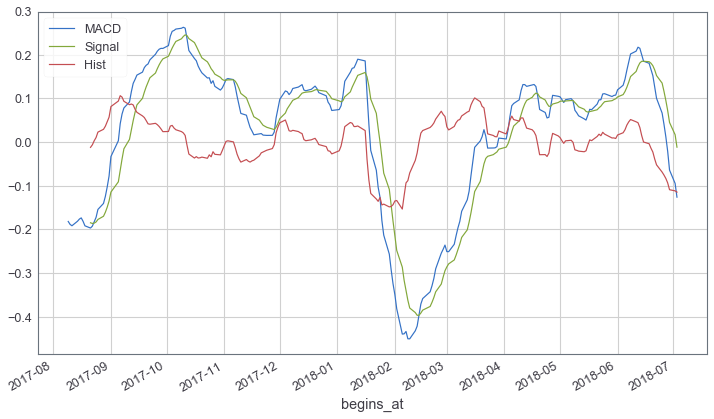

In [20]:
jp_macd = MACD(close)
jp_macd.plot(figsize=(12,7))
plt.show()

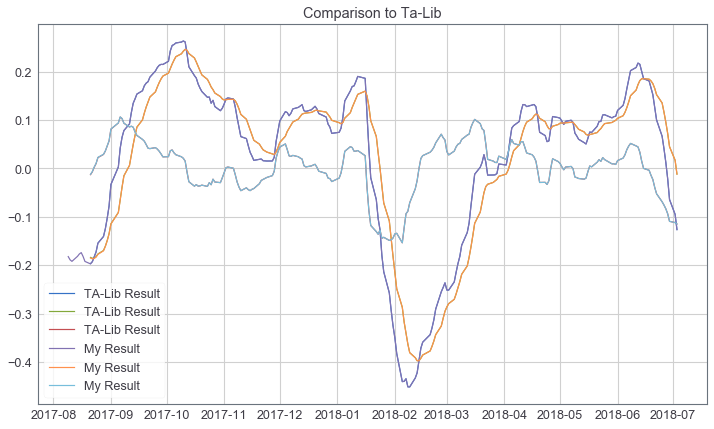

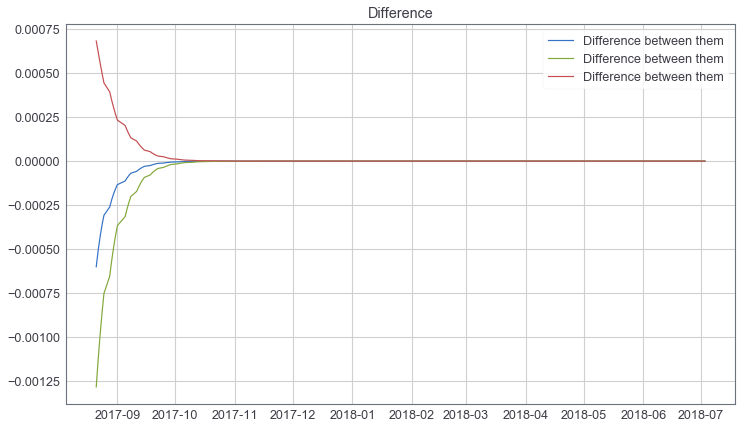

In [21]:
perform_test(jp_macd, ta_macd)

# 지표 설명 : Fast STC

Fast STC (Stochastic Fast) <br>
스토캐스틱 (일반적으로 fast stochastic 을 그냥 스토캐스틱이라 부름)

스토캐스틱(stochastic)은 조지 레인(Geroge C. Lane)이 만든 지표이다. 이 지표는 주가가 상승추세를 보이고 있을 때에는 오늘의 종가가 최근 며칠 동안의 거래범위(trading range) 중에서 최고점 부근에서 형성되는 경향이 높고, 반대로 주가가 하락추세를 보이고 있을 때에는 오늘의 종가가 최근 며칠 동안의 거래범위 중에서 최저점 부근에서 형성되는 경향이 높다는 점에 원리를 두고 있다.

스토캐스틱을 산출하는 공식은 다음과 같다.

### $\%K = \frac{C-L5}{H5-L5} ×100$ 
### $\%D = SMA(\%K,3)$

C : 오늘의 종가 <br>
L5 : 최근 5일간 최저가 <br>
H5 : 최근 5일간 최고가 <br>

### Parameters : fastk_period(%K)=5, fastd_period(%D)=3

*Note : Stochastic은 과거 일정한 기간 동안(일반적으로 5일을 사용한다)의 가격 움직임 중에서 오늘의 종가가 어느 위치에 있는가를 파악하는 것이 목적이다. 그리고 이것을 이용하여 현재의 추세와 시장상황을 파악한다.*

### 매매 방법 
*%K 곡선이 %D 곡선 상향 돌파 -> 매수* <br>
*%K 곡선이 %D 곡선 하향 돌파 -> 매도* <br>
*Note : 이때 %K의 값이 과열권을 나타내거나 또는 과매도상태라면 매매신호의 신뢰도는 더욱 높다. <br>
>%K의 값이 100 언저리일 때에 하향돌파가 일어나면 강력한 매도신호이고 %K의 값이 0 언저리일 때에 상향돌파가 일어나면 강력한 매입신호이다.

### 직접만든 함수

In [304]:
def SMA(close, timeperiod=5):  # timeperiod = n일간 이평선 결정
    return close.rolling(window=timeperiod).mean()

In [305]:
def get_per_k(idx,high,low,close):
    idx = idx.astype(int)
    h_5 = high.iloc[idx[0]:idx[-1]+1].max()
    l_5 = low.iloc[idx[0]:idx[-1]+1].min()
    c = close.iloc[idx[-1]]
    return (c-l_5) / (h_5-l_5) * 100
def STOCHF(high, low, close, fastk_period=5, fastd_period=3):
    idx = pd.Series(np.arange(len(close)))
    per_k = idx.rolling(window=fastk_period).apply(lambda x : get_per_k(x,high,low,close))
    per_k.index = close.index
    per_d = SMA(per_k,fastd_period)
    return per_k, per_d

In [306]:
per_k, per_d = STOCHF(high,low,close)

### Talib 함수

In [307]:
# talib version
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
fastk, fastd = talib.STOCHF(h, l, c, 5, 3, 0)
fastk = pd.Series(fastk, index=return_index)
fastd = pd.Series(fastd, index=return_index)

### 비교하기

In [308]:
print((per_k - fastk).mean()) # 거의 일치함을 확인
print((per_k - fastk).std())

-2.0845003727656001e-16
5.458764111686276e-15


In [309]:
print((per_d - fastd).mean()) # 거의 일치함을 확인
print((per_d - fastd).std())

2.1055266373952357e-14
2.061501636725552e-14


# 지표설명 : Slow STC

Slow STC (Stochastic Slow) <br>
완만한 스토캐스틱

스토캐스틱(Stochastic Fast)을 사용해보면 신호가 너무 자주 나타나서 혼란스럽다. 그래서 이 지표는 Fast STC의 민감도를 약간 낮추면서 동시에 안정성을 높이기 위하여 개발되었다. 이 지표는 Stochastic을 산출하는 과정에서 이동평균을 한 차례 추가하여 곡선을 완만하게(smoothing out) 한 것이다.

완만한 스토캐스틱을 산출하는 공식은 다음과 같다.

우선 첫 번째 단계로 원래의 Stochastic 에서처럼 %K와 %D 곡선을 각각 산출한다.

두 번째 단계로 %D곡선을 다시 한 번 3일간 이동평균한다. 그리고는 기존의 %D곡선에 '슬로우 %K곡선(slow %K)' 이라는 이름을 붙이고, %D곡선을 다시 한 번 3일간 이동평균한 곡선에 '슬로우 %D곡선(slow %D)'이라는 이름을 붙인다. 마지막 단계로 처음의 %K 곡선을 제거하고 슬로우 %K 곡선과 슬로우 %D곡선을 이용하여 매매타이밍을 포착한다.

### Parameters : fastk_period(기간)=5, slowk_period(%K)=3, slowd_period(%D)=3

*Note : (5-3-3)의 파라미터를 기본적으로 사용하지만 분석가에 재량에 따라 (10-6-6), (14-7-7) 등으로 변경 가능, 산출기간이 길어질수록 Stochastic은 더욱 더 안정적으로 바뀌지만 그만큼 민감도는 저하된다. 결국 **안정성과 민감도는 하나를 얻으려면 다른 하나를 포기하여야 하는 관계, 즉 두 가지를 한꺼번에는 충족할 수 없는, 트레이드 오프(trade-off) 관계이다.***

### 매매 방법 
*%K 곡선이 %D 곡선 상향 돌파 -> 매수* <br>
*%K 곡선이 %D 곡선 하향 돌파 -> 매도* <br>
*Note : 이때 %K의 값이 과열권을 나타내거나 또는 과매도상태라면 매매신호의 신뢰도는 더욱 높다. <br>
>%K의 값이 100 언저리일 때에 하향돌파가 일어나면 강력한 매도신호이고 %K의 값이 0 언저리일 때에 상향돌파가 일어나면 강력한 매입신호이다.

In [31]:
# 직접만든 함수
def STOCHS(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3):
    per_k, per_d = STOCHF(high,low,close,fastk_period, slowd_period)
    slow_k = per_d
    slow_d = SMA(per_d,slowk_period)
    return slow_k, slow_d

In [36]:
# Talib 함수
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
slowk, slowd = talib.STOCH(h, l, c, 5, 3, 0, 3, 0)
slowk = pd.Series(slowk, index=return_index)
slowd = pd.Series(slowd, index=return_index)

In [33]:
slow_k, slow_d = STOCHS(high, low, close)

In [34]:
print((slow_k - slowk).mean()) # 거의 일치함을 확인
print((slow_k - slowk).std())

2.1010515731594765e-14
2.084077711490005e-14


In [35]:
print((slow_d - slowd).mean()) # 거의 일치함을 확인
print((slow_d - slowd).std())

1.115683137861018e-14
5.755851212594539e-14


# 지표설명 : RSI

RSI (Relative Strength Index) <br>
상대강도지수

상대강도지수(RSI)는 현재의 시장 상황이 과열(Overbought)된 상태인지 아니면 과매도(Oversold)된 상태인지, 또는 이것도 저것도 아닌 상태인지를 파악하려는 목적으로 개발된 기술적지표이다. 주가의 상승 속도, 또는 더 구체적으로 말한다면 현재 시장의 분위기를 객관적으로 나타내주는 지표 중에서는 단연 대표적이다. 또한 매매 타이밍을 잡아내며, 동시에 주가와 RSI의 관계에서 다이버전스를 찾아내 추세전환의 결정적인 신호를 제공하는 등 여러 가지 측면에서 빼어난 기술적지표이다. 기술적 분석에 관심이 있는 투자자라면 반드시 알아두어야 할 지표이다.

RSI는 다음과 같은 공식에 의하여 산출된다.

### $RSI = 100 \,\,–\, \frac{100}{1\,+\,RS}$
### $RS = \frac{Average\, Gain}{Average\, Loss}$
### $First \,Average\, Gain = 데이터에서 \,첫 \,14일의\, 수익\, 평균$
### $First\, Average\, Loss = 데이터에서\, 첫\, 14일의\, 손실\, 평균$
### $Average \,Gain = \frac{이전일\, 까지의\, Average\, Gain\, ×\, 13\, +\, 오늘자\, 수익}{14}$
### $Average \,Loss = \frac{이전일\, 까지의\, Average\, Loss\, ×\, 13\, +\, 오늘자\, 손실}{14}$

### Parameters : time_period(기간)=14

### Calculation Example

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5b4ded8ccc3ae6939b3289b5/5b513e025e8ad6c4207b90f1f4fb8b5f/image.png">

The very first calculations for average gain and average loss are simple 14-period averages. <br><br>

First Average Gain = Sum of Gains over the past 14 periods / 14. <br>
First Average Loss = Sum of Losses over the past 14 periods / 14 <br>
The second, and subsequent, calculations are based on the prior averages and the current gain loss:  <br> <br>

Average Gain = [(previous Average Gain) x 13 + current Gain] / 14. <br>
Average Loss = [(previous Average Loss) x 13 + current Loss] / 14. <br>

http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:relative_strength_index_rsi

Average Gain 계산 시 iteration 하여 과거의 information 을 버리지 않고 사용함

### 매매 방법 
*두 가지의 매매 방식이 존재한다.*
1. RSI가 30 선을 하향돌파 했을 때 -> 매수 <br>
   RSI가 70 선을 상향돌파 했을 때 -> 매도 <br><br>
   
2. RSI가 30 선을 하향돌파 한 직후 다시 상향돌파 할 때 -> 매수 <br>
   RSI가 70 선을 상향돌파 한 직후 다시 하향돌파 할 때 -> 매도 <br>

In [116]:
def calc_rsi(data):
    data = pd.Series(data)
    diff = data.rolling(window=2).apply(lambda x : x[1]-x[0])
    u = diff.where(diff>0).sum()
    d = -diff.where(diff<0).sum()
    return u/(u+d) * 100
    
def RSI(close, time_period=14):
    rsi = close.rolling(window=time_period+1).apply(calc_rsi) 
    return rsi

In [117]:
rsi = RSI(close,14)

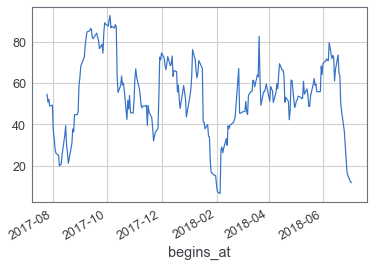

In [118]:
rsi.plot()

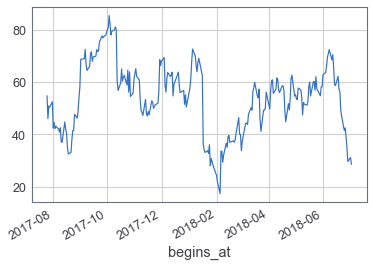

In [119]:
# Talib 함수
return_index = close.index
c = np.array(close, dtype='f8')
ta_rsi = talib.RSI(c,14)
talib_rsi = pd.Series(ta_rsi, index=return_index)
talib_rsi.plot()

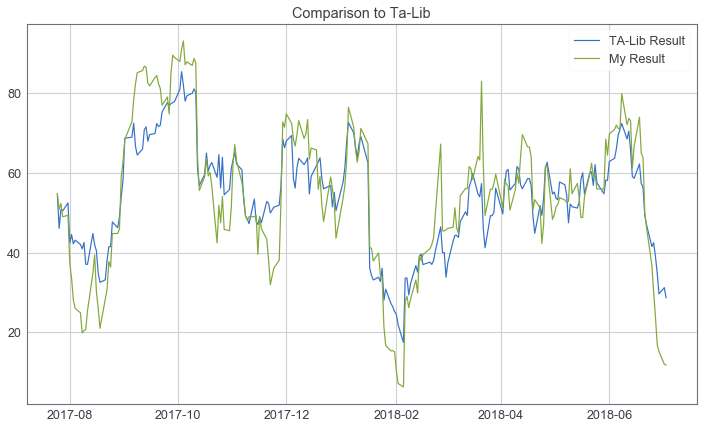

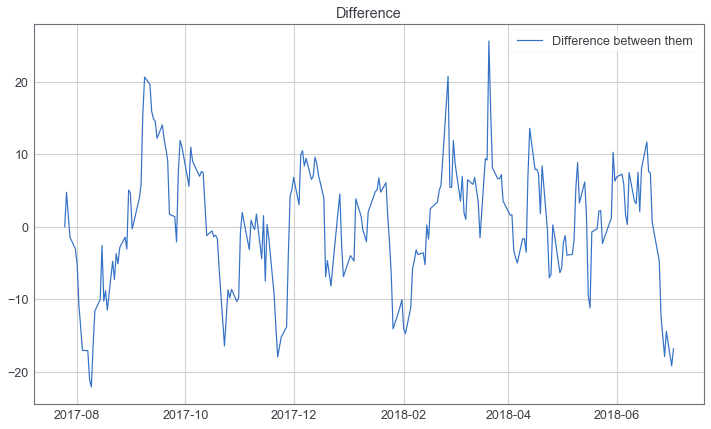

In [121]:
perform_test(rsi, talib_rsi)

In [159]:
a = [44.34, 44.09, 44.15, 43.61, 44.33, 44.83, 45.10, 45.42, 45.84, 46.08, 45.89, 46.03, 45.61, 46.28, 46.28, 46.00, 46.03,
    46.41, 46.22, 45.64, 46.21, 46.25, 45.71, 46.45, 45.78, 45.35, 44.03, 44.18, 44.22, 44.57, 43.42, 42.66, 43.13]

In [161]:
sa = pd.Series(a)
len(sa)

33

In [171]:
def initial_gain_loss(data):
    data = pd.Series(data)
    diff = data.rolling(window=2).apply(lambda x : x[1]-x[0])
    u = diff.where(diff>0).sum()
    d = -diff.where(diff<0).sum()
    return u,d
    
def RSI(close, time_period=14):
    diff = close.rolling(window=2).apply(lambda x : x[1]-x[0])
    avg_gain = pd.Series(index=close.index)
    avg_loss = pd.Series(index=close.index)
    u,d = initial_gain_loss(close.iloc[:time_period+1])
    avg_gain.iloc[time_period] = u/time_period 
    avg_loss.iloc[time_period] = d/time_period
    for i in range(time_period+1, len(close)):
        current_gain = 0
        current_loss = 0
        if(diff.iloc[i] > 0):
            current_gain = diff.iloc[i]
        else:
            current_loss = -diff.iloc[i]
        
        avg_gain.iloc[i] = (avg_gain.iloc[i-1] * (time_period-1) + current_gain) / time_period
        avg_loss.iloc[i] = (avg_loss.iloc[i-1] * (time_period-1) + current_loss) / time_period
    return avg_gain / (avg_gain + avg_loss) * 100

In [173]:
rsi = RSI(close,14)

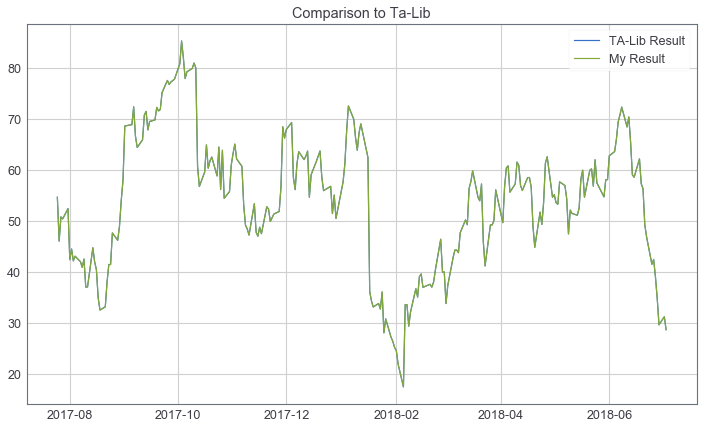

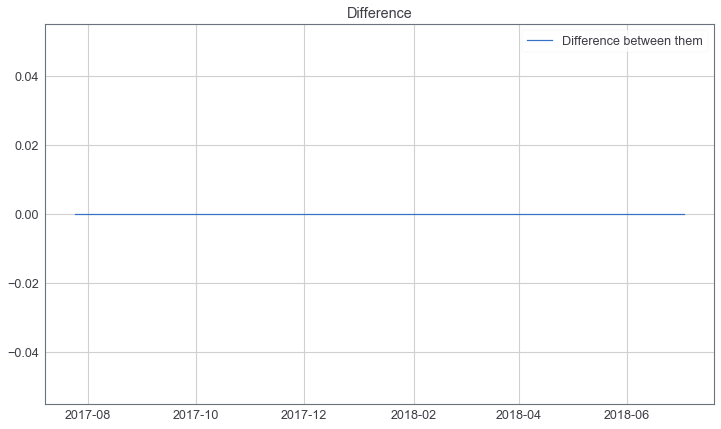

In [174]:
perform_test(rsi,talib_rsi)

# 지표설명 : OBV

OBV (On Balance Volume) <br>
누적 거래량

대표적인 거래량 지표로 주가가 상승하면 그날의 거래량을 더하고, 주가가 하락하면 그날의 거래량을 빼는 다눗ㄴ한 방식이지만 시장의 흐름을 정확하게 포착하는 장점을 가진다. 일관된 기준일자가 없이 분석가가 재량으로 설정하여야 한다는 것이 단점이며 과열, 과매도 등의 비정상적인 상황을 잡아내지 못하는 것도 역시 단점의 하나이다.

OBV는 다음과 같은 공식에 의하여 산출된다.

### $당일종가 \geq 전일종가$  :  $OBV=OBV_{-1} + 당일거래량$
### $당일종가 < 전일종가$  :  $OBV=OBV_{-1} - 당일거래량$

### Parameters : 없음

### 매매 방법 
- *거래량이 주가를 선행하듯이 OBV 역시 주가를 선행한다.* <br>
- *특히 전고점이나 전저점의 돌파여부를 살피는 것이 매우 중요하다.* <br>
- *만일 OBV가 전고점을 뚫고 상승세를 이어간다면 주가도 전고점을 넘어 상승세를 이어갈 것으로 예상된다. 반대로 OBV가 전저점을 무너뜨리고 하락세를 이어간다면 주가도 전저점을 돌파하여 하락세를 이어갈 것으로 예상하는 것이 합당하다.* <br>
- *또한 OBV와 주가와의 관계에서 다이버전스(괴리)가 나타날 때마다 매매 타이밍으로 간주하여야 한다. 예컨대 주가는 계속 상승하는데, OBV가 더 이상 상승하지 못하고 횡보양상을 나타내거나 심지어 하락한다면 이는 강력한 추세전환 신호이다. 조만간 상승추세는 끝나고 하락추세가 시작된다는 신호로 간주되므로 매도 타이밍이다. 반대로 주가는 계속 하락하는데 OBV가 더 이상 하락하지 않고 횡보양상을 나타내거나 또는 상승한다면 역시 강력한 추세전환 신호이다. 조만간 하락추세는 끝나고 상승추세가 시작된다는 신호로 간주되므로 매입 타이밍이다.*

In [1]:
def OBV(close,volume):
    v = 0
    obv = pd.Series(index=close.index)
    obv.iloc[0] = volume.iloc[0]
    for i in range(1,len(close)):
        # if close.iloc[i] >= close.iloc[i-1] : 
        if close.iloc[i] > close.iloc[i-1] : # 차트의 정석 책에는 등호 포함인데 talib 에서는 등호 안쓰고 만든듯
            obv.iloc[i] = obv.iloc[i-1] + volume[i]
        elif close.iloc[i] < close.iloc[i-1] :
            obv.iloc[i] = obv.iloc[i-1] - volume[i]
    return obv

In [7]:
obv = OBV(close,volume)
obv.head()

begins_at
2017-07-05    39412233.0
2017-07-06     7476249.0
2017-07-07    28348097.0
2017-07-10    47229379.0
2017-07-11    73143712.0
dtype: float64

In [8]:
return_index = close.index
c = np.array(close, dtype='f8')
v = np.array(volume, dtype='f8')
t_obv = talib.OBV(c, v)
talib_obv = pd.Series(t_obv, index=return_index)

In [9]:
# talib 결과와 일치
print((obv-talib_obv).mean())
print((obv-talib_obv).std())

0.0
0.0


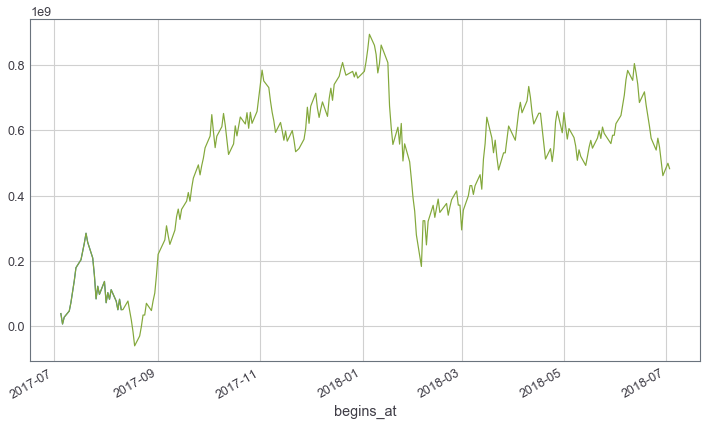

In [10]:
obv.plot(figsize=(12,7))
talib_obv.plot()
plt.show()

# 지표설명 : CCI

CCI (Commodity Channel Index) <br>
추세채널지수

평균으로의 회귀(Mean Reverting) 속성을 활용한 것으로 매매지표라기보다는 시장이 정상인지 비정상인지 알려주는 경계신호에 가까움. 괴리(divergence)를 찾는 것이 훨신 효과적임

CCI는 다음과 같이 산출된다.

## $CCI=\frac{1}{0.015}\frac{p_t-SMA(p_t)}{MD(p_t)}$

## $p_t = \frac{p_{high}+p_{low}+p_{close}}{3}$

### $SMA$ : simple moving average(단순 이동 평균)

### $MD$ : mean absoute deviation

### Parameters : time_period(기간)=20

### 매매 방법 
- *CCI는 이동평균과 주가 사이의 괴리도가 어느 정도 수준인지를 나타낸다.* <br>
- *그러므로 CCI의 값이 클수록 현재의 주가는 이동평균에서 많이 떨어져 있다는 의마가 된다.* <br>
- *CCI의 값이 (+)로 나타난다면 현재의 주가는 상승추세이고, 반대로 CCI의 값이 (-)로 나타난다면 현재의 주가는 하락추세인 것으로 파악된다.* <br>
- *CCI의 값은 +100을 넘어서기도 하는데, +100을 돌파하여 더 커질수록 현재의 추세는 상승세이지만 추세의 강도가 과열되고 있음을 나타낸다. 따라서 CCI가 +100을 넘어 선다면 매도기회로 인식한다. (+)로 나타난다면 현재의 주가는 상승추세이고, 반대로 CCI의 값이 (-)로 나타난다면 현재의 주가는 하락추세인 것으로 파악된다.* <br>
- *반대로 CCI의 값이 -100 이하로 내려선다면 이를 매입기회로 본다.* <br>

### *Talib Code*

In [12]:
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
cci = talib.CCI(h, l, c, 20)
talib_cci = pd.Series(cci, index=return_index)

In [26]:
def mad(data): # Mean Absolute Deviation
    return pd.Series(data).mad()

In [30]:
def CCI(high,low,close,time_period=20):
    M = (high+low+close) / 3
    m = SMA(M,time_period)
    d = M.rolling(window=time_period).apply(mad)
    return (M-m)/d / 0.015 

In [31]:
cci = CCI(high,low,close)

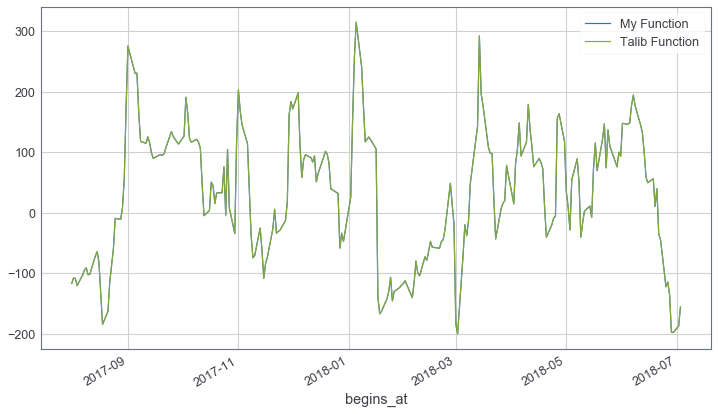

In [32]:
cci.plot(figsize=(12,7),label='My Function')
talib_cci.plot(label='Talib Function')
plt.legend()
plt.show()

# 지표설명 : VR

VR (Volume Ratio) <br>

일정기간 동안에 걸쳐 주가상승일의 거래량과 주가하락일의 거래량간의비율을 나타낸 것으로서 보통 1개월간(입회일수 25일)의 거래량을 기준으로 하는데 주가상승일의 거래량합계를 하락일의 거래량 합계로 나눈것이다. 주가가 변동하지 않은 날의 거래량의 반은 상승일에, 나머지 반은 하락일의 거래량 합계에 더하여 계산한다.

VR은 다음과 같이 산출된다.

### $VolumeRatio = \frac{상승일의\, 거래량합계\, +\, 변동\, 없는\, 날의\, 거래량\, 절반}{하락일의\, 거래량합계\, + \,변동 \,없는 \,날의 \,거래량 \,절반} × 100$

### 매매 방법 
- VR 수치가 150% 이면 보통, 300% 를 초과하면 강세, 450% 를 초과하면 과열이라고 판단
- 예를 들어 VR이 300%라면 대체로 주가상승시의 거래량이 주가하락시의 거래량의 3배라고 할 수 있다.우리 나라 증권시장의 경험에 비추어 보면, 대체로 강세시장일 경우에는 주가가 상승하는 날의 거래량이 주가가 하락하는 날의 거래량보다 많고, 반대로 약세시장일 때에는 하락일의 거래량이 상승일의 거래량보다 많았다. 따라서 VR은 150% 내외가 되는 경우가 가장 많이 나타나고 450%를 초과하면 대개 천정권으로 판단하여 단기적으로 주가의 경계신호가되며, 70% 이하이면 바닥권으로 판단한다.
- *Note : 이 지표는 주가가 천정권일 때보다는 바닥권일 때가 더 신뢰도가 높게나타나는 것으로 알려져 있다.*

In [33]:
def vr_score(idx,pc,volume):
    
    idx = idx.astype(int)
    pc = pc.iloc[idx[0]:idx[-1]+1]
    volume = volume.iloc[idx[0]:idx[-1]+1]
    up_volume = volume[pc.where(pc==1).dropna().index].sum()
    down_volume = volume[pc.where(pc==-1).dropna().index].sum()
    stay_volume = volume[pc.where(pc==0).dropna().index].sum()
    
    if np.isnan(up_volume) :
        up_volume = 0
    if np.isnan(down_volume) :
        down_volume = 0
    if np.isnan(stay_volume) :
        stay_volume = 0
        
    try:
        score = (up_volume + 0.5 * stay_volume) / (down_volume + 0.5*stay_volume) * 100
        return score
    except:
        return np.inf
def VR(close, volume, time_period=25):
    pc = close.pct_change()
    pc[pc.where(pc>0).dropna().index] = 1
    pc[pc.where(pc<0).dropna().index] = -1
    idx = pd.Series(np.arange(len(pc))).astype(int)
    vr = idx[1:].rolling(window=time_period).apply(lambda x : vr_score(x,pc,volume))
    vr.index = close.index[1:]
    return vr

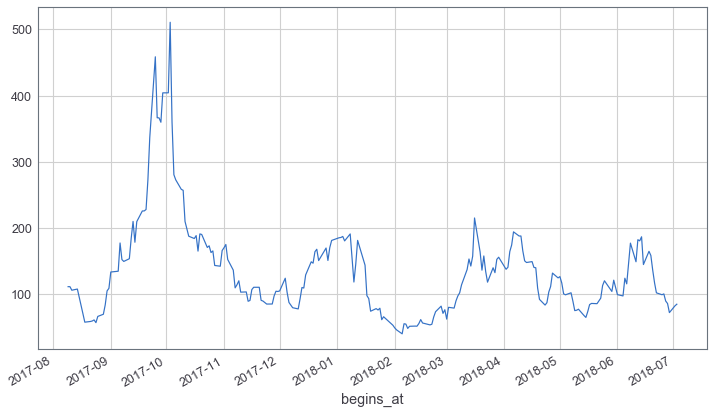

In [34]:
VR(close,volume).plot(figsize=(12,7))
plt.show()

# 지표설명 : 투자심리도

매우 단순한 기술적지표이지만 현재의 시장이 과열권인지 과매도권인지를 알려준다. 오랜 역사를 가지고 있는데도 지금까지 사용되고 있으니 그만큼 유용성도 있다는 증거가 된다. 다만 주가의 변동폭보다는 상승하거나 하락한 기간을 위주로 산출되므로 민감도가 낮고 정확도 역시 저하된다는 단점은 피할 수 없다.

투자심리도는 다음과 같이 산출된다.

### 투자심리도 =  $\frac{최근\, 12일간 \,시장가격이 상승한 일수}{12} × 100$

### 매매 방법 
- 일반적으로 투자심리도가 75 이상이면 현재의 주식시장은 비정상적인 과열권으로 간주된다. 이는 최근 12일 동안에 9일 이상 주가가 올랐다는 것을 뜻하므로 현재의 주식시장 상황에서 상승세가 지나친 것으로 판단된다. 따라서 시장은 상승세이지만 투자심리도가 75 이상이라면 과열된 것으로 판단하여 매도 하여야 한다.
- 반면 투자심리도가 25 이하라면 현재의 주식시장은 비정상적인 과매도권으로 간주된다. 이는 최근 12일 동안에 주가가 오른 기간은 3일 이하에 불과하다는 것을 뜻하므로 현재의 주식시장 상황에서 하락세가 지나친 것으로 판단된다. 따라서 현재의 시장은 하락세이지만 투자심리도가 25이상이라면 바닥이 멀지 않았으므로 매수 타이밍으로 간주된다.
- *Note : 투자 심리도는 주가의 등락폭을 고려하지 않는다 따라서 매매의 의사결정에 이 지표를 단독으로 사용하는 것은 위험하다. 다른 지표의 보조적인 지표로 사용되어야 한다.*

In [36]:
def PSYIND(close, time_period=12):
    pc = close.pct_change()
    pc[pc.where(pc>0).dropna().index] = 1
    pc[pc.where(pc<=0).dropna().index] = 0
    psyind = pc.rolling(window=time_period).sum()
    return psyind / time_period * 100

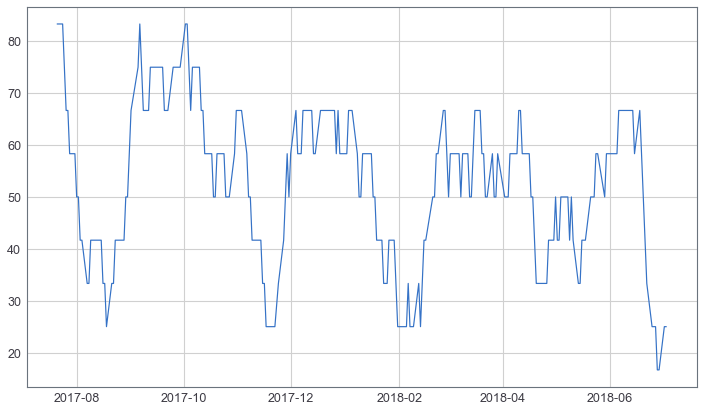

In [37]:
plt.figure(figsize=(12,7))
plt.plot(PSYIND(close))
plt.show()

# 지표설명 : ROC

ROC (Rate of Change) <br>

ROC는 과거 일정시점의 가격과 대비한 현재가격의 상승률로서 추세의 반전을 알려주는 지표로 사용되며 다음의 공식에 의해 산출된다.

### $ROC =\frac{금일종가 - N일전의 종가}{N일전의 종가} × 100\,\,(\%)$

### Parameters : time_period(기간)=12

### 매매방법
- ROC가 0선을 상향돌파 -> 매수
- ROC가 0선을 하향돌파 -> 매도
- 주가와 움직임에서 Divergence 를 찾을 수 있음(주가는 상승 또는 하락추세를 유지하지만 ROC가 직전 고점이나 직전 저점 돌파의 실패)

In [4]:
def ROC(close, time_period=12):
    roc = close.rolling(window=time_period+1).apply(lambda x : (x[-1] - x[0])/x[0] * 100 )
    return roc

In [10]:
def ROC2(close, time_period=12):
    shift = close.shift(time_period+1)
    return (close - shift)/shift * 100

In [5]:
return_index = close.index
c = np.array(close, dtype='f8')
talib_roc= talib.ROC(c, 12)
talib_roc = pd.Series(talib_roc, index=return_index)

In [8]:
%timeit roc = ROC(close,12)

568 µs ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%timeit roc2 = ROC2(close,12) # 이걸로 쓰는게 약간 더 빠름

369 µs ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


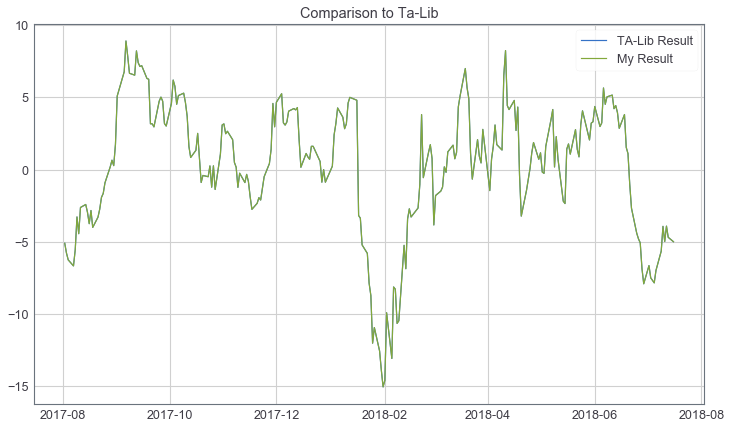

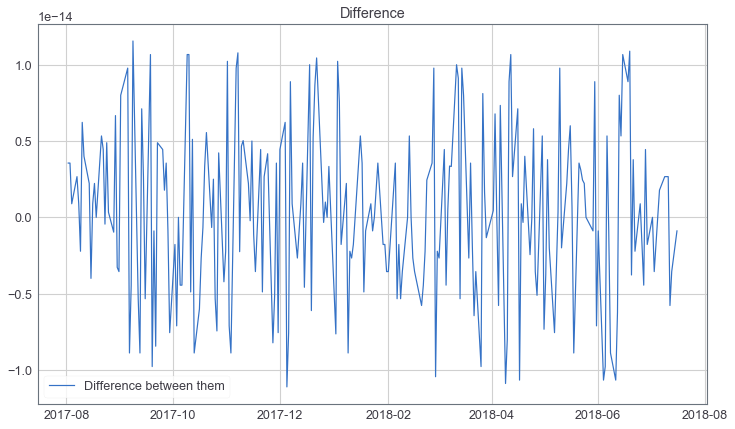

In [19]:
perform_test(roc2,talib_roc)

# 지표설명 : SONAR (talib에 없음)

SONAR <br>
소나

SONAR는 노무라증권에서 개발된 지표로 주가 사이클의 변곡점을 찾아 매매시점으로 활용하고자 하는 Momentum지표이다. 즉 주가의 변화를 물리적 운동으로 파악하고 주가의 평균변화율의 추이를 분석함으로써 주가를 예측하고자 하였다.<br>
장, 단기이동평균을 차감하는 단순한 방법으로 만들어진 지표이며 단순히 SONAR만을 이용하기보다는 그것의 *지수이동평균(Exponential Moving Average)*을 함께 사용하면 훨씬 안정성을 높일 수 있다.

SONAR 는 다음과 같이 계산된다.

### $SONAR = EMA_0 - EMA_{-n}$

일반적으로 지수이동평균에는 9일이 사용되며, 통상 오늘의 지수이동평균에서 6일 이전의 지수이동평균을 차감하는 방식으로 쓰인다. <br>
시그널 곡선의 경우 5일 지수이동평균을 주로 사용한다.

### Parameters : timeperiod(지수이평)=9, timestep(기간)=6, signal_period(시그널기간)=5

### 매매방법
- 기준선의 교차
> 주가와 이동평균선과의 이격도가 크지않을 경우에 적합한 분석기법으로 SONAR가 기준선(0 라인)을 상향 돌파할 때는 매수 신호, 하향 돌파할 때는 매도신호를 나타낸다.
- 시그널 곡선과의 교차
> 단기적인 주가의 급격한 변화가 있을 경우에는 주가와 이동평균선과의 격차가 커지게 된다. 이때에는 SONAR의 지수이동평균을 구해(시그널 곡선) SONAR가 시그널 곡선을 상향 돌파 시에는 매수신호, 하향 돌파 시에는 매도신호로 분석한다.

In [56]:
def SONAR(close, timeperiod=9, timestep=6, signal_period=5):
    sonar = pd.Series(index=close.index)
    ema = EMA(close, timeperiod)
    sonar = ema.rolling(window=timestep+1).apply(lambda x : (x[-1] - x[0]) )
    return sonar, EMA(sonar, signal_period)

In [58]:
sonar = SONAR(close)

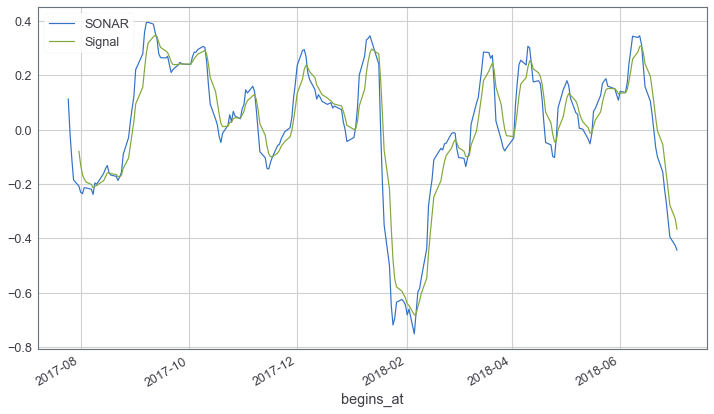

In [61]:
df = pd.DataFrame([sonar[0],sonar[1]]).T
df.columns = ['SONAR','Signal']
df.plot(figsize=(12,7))
plt.show()

# 지표설명 : TRIX

TRIX <br>
트릭스

지수이동평균은 단순이동평균이 지니고 있는 약점, 즉 시차(time lag)문제를 해결하기 위한 방안으로 고안된 것이다. 지수이동평균을 여러 차례 반복함으로써 이동평균의 산출기간보다 더 짧은 초단기의 가격 등락은 걸러낼 수 있으므로 그만큼 지수의 신호가 안정적이 된다.

트릭스의 산출방식은 다음과 같다.

### $M = EMA(EMA(EMA(close)))$
### $TRIX = \frac{M-M_{-1}}{M} × 100$

### Parameters : time_period(지수이평기간)=15, signal_period(시그널기간)=9

### 매매방법
- 트릭스가 시그널 곡선을 상향돌파 -> 매수
- 트릭스가 시그널 곡선을 하향돌파 -> 매도

In [117]:
def TRIX(close, time_period=15, signal_period=9):
    first_ema = EMA(close,time_period)
    second_ema = EMA(first_ema,time_period)
    triple_ema = EMA(second_ema,time_period)
    trix = ROC(triple_ema,1)
    signal = EMA(trix,signal_period)
    return trix, signal

In [121]:
trix, signal = TRIX(close,30,9) # talib 에서는 30일을 dafault로 사용, but 다른 온라인 공식들에서는 15일 사용

In [119]:
return_index = close.index
c = np.array(close, dtype='f8')
talib_trix= talib.TRIX(c)
talib_trix = pd.Series(talib_trix, index=return_index)

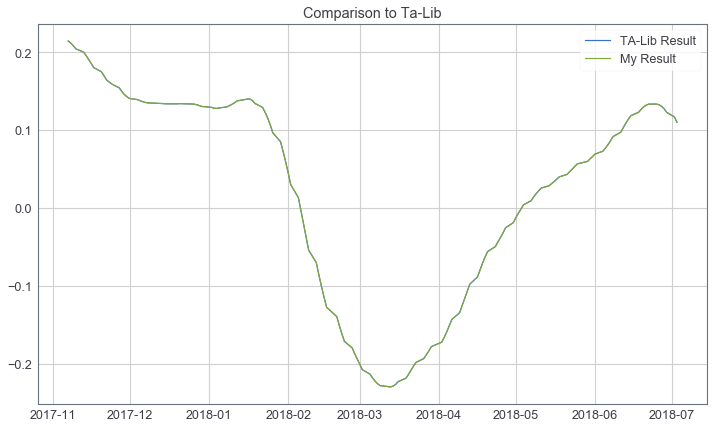

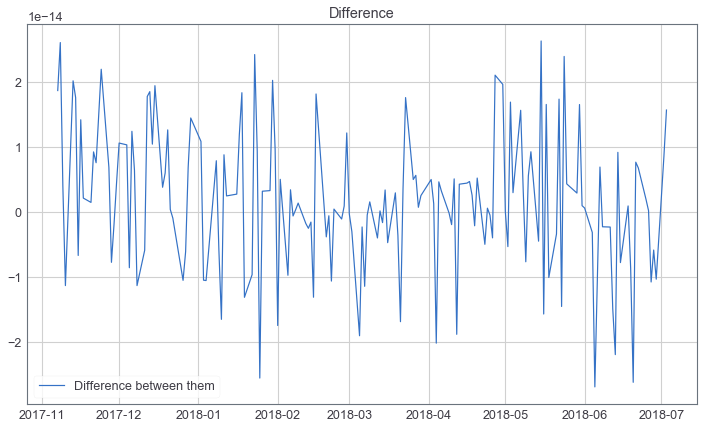

In [120]:
perform_test(trix, talib_trix)

# 지표설명 : DMI

DMI (Directional Movement Index) <br>
방향성지수

방향성 지수(DMI, Directional Movement Index)는 주가의 방향성을 알려주도록 고안된 추세이다. 1978년에 웰러스 윌더(Welles Wilder Jr.)가 개발하였다.

DMI, DX, ADX, ADXR 은 세트로 묶여있는 지표로 설명이 복잡해서 온라인 링크로 대체합니다.

https://www.forexliga.kr/forum/view.php?idx=17603

https://booja.blogspot.com/2012/08/hts.html

DMI -> +DM, -DM, +DI, -DI 4개 계산해야함

이후에 나오는 DX, ADX, ADXR 지표와 이어짐, 자세한 설명은 나중에 정리

### Parameters : time_period(기간)=14

### 매매방법
- +DI는 상승추세의 강도를 나타내고, -DI는 하락추세의 강도를 나타낸다. 따라서 +DI가 계속 증가한다는 것은 그만큼 시장에서 주가의 상승세가 증가하고 있는 것으로 파악할 수 있다. 반대로 -DI가 계속 증가한다는 것은 그만큼 시장에서 주가의 상승세가 증가하고 있는 것으로 파악할 수 있다.
- +DI선이 -DI선을 상향돌파한다면 그때부터 상승추세의 강도가 하락추세의 강도를 넘어선 시기로 간주하여 매수기회로 포착한다.
- 반대로 -DI선이 +DI선을 상향돌파한다면 그때부터 하락추세의 강도가 상승추세의 강도를 넘어선 시기로 간주하여 매도기회로 포착한다.

In [9]:
def cum_sum(data,period):
    s = pd.Series(index=data.index)
    s.iloc[:period-1] = [np.NaN] * (period-1)
    s.iloc[period-1] = data.iloc[:period].sum()
    for i in range(period,len(data)):
        s[i] = (1-1/period) * s[i-1] + data[i]
    return s

In [14]:
%timeit cum_sum(close,5)

16 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [206]:
def DMI(high,low,close,time_period=14):
    
    delta_high = high.rolling(window=2).apply(lambda x : x[1] - x[0])
    delta_low =  low.rolling(window=2).apply(lambda x : x[0] - x[1])
    
    true_high = pd.DataFrame([high,close.shift(1)]).max(axis=0, skipna=False)
    true_low = pd.DataFrame([low,close.shift(1)]).min(axis=0, skipna=False)
    
    tr = true_high - true_low
    pc = delta_high - delta_low
    
    plus_dm = pd.Series(np.zeros(len(close)), index=close.index)
    minus_dm = pd.Series(np.zeros(len(close)), index=close.index)
    
    ind1 = set(delta_high.where(delta_high < 0).dropna().index)
    ind2 = set(delta_low.where(delta_low < 0).dropna().index)
    neg_ind = ind1.intersection(ind2)
        
    plus_index = set(pc.where(pc>0).dropna().index) - neg_ind
    minus_index = set(pc.where(pc<0).dropna().index) - neg_ind
    
    plus_dm[plus_index] = delta_high[plus_index]
    minus_dm[minus_index] = delta_low[minus_index]
    
    plus_dm_sum = cum_sum(plus_dm,time_period)
    minus_dm_sum = cum_sum(minus_dm,time_period)
    
    tr_sum = cum_sum(tr,time_period)
    
    plus_di = plus_dm_sum / tr_sum * 100
    minus_di = minus_dm_sum / tr_sum * 100
    
    return plus_dm_sum, minus_dm_sum, plus_di, minus_di

In [207]:
d = DMI(high,low,close)

c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


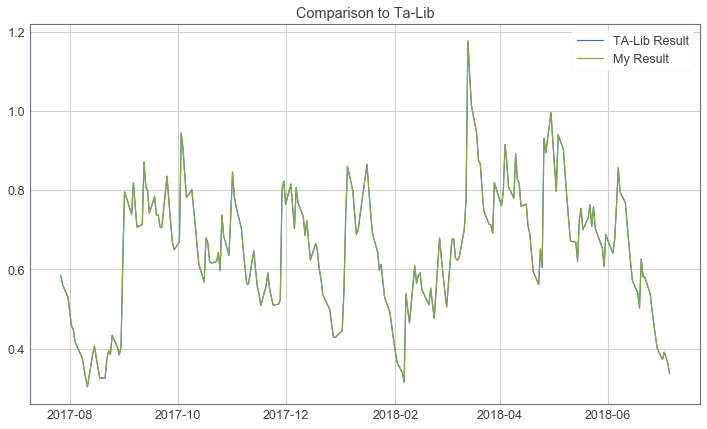

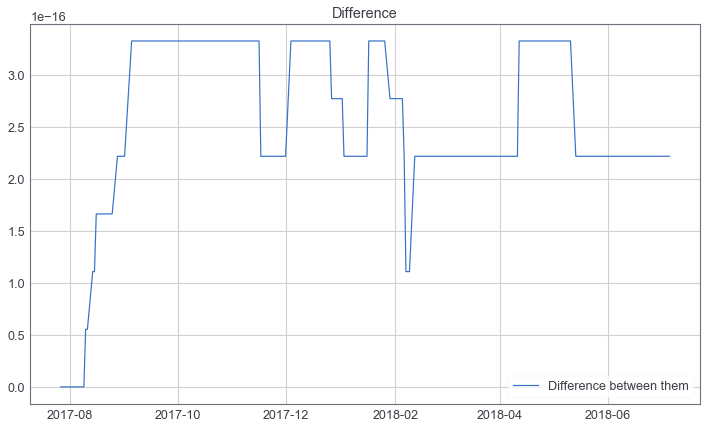

In [208]:
return_index = high.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
plus_dm = talib.PLUS_DM(h, l, 14)
plus_dm = pd.Series(plus_dm, index=return_index)
perform_test(d[0], plus_dm)

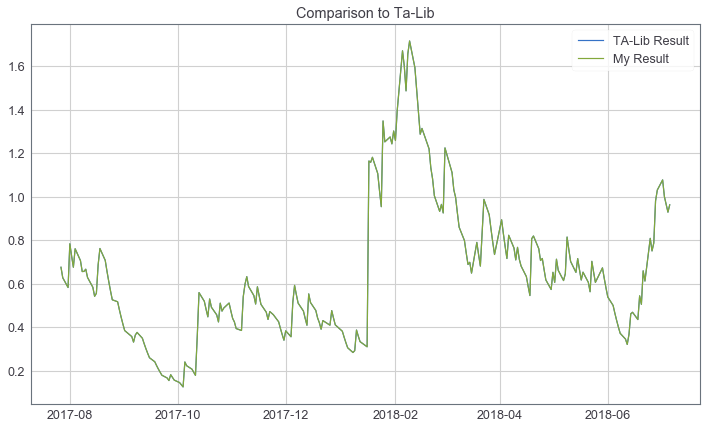

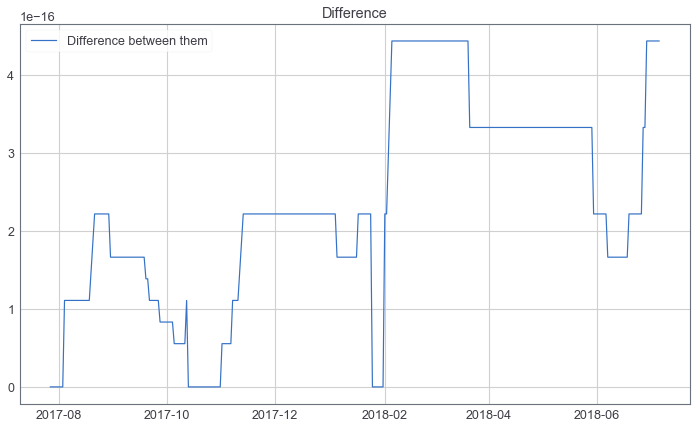

In [186]:
return_index = high.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
minus_dm = talib.MINUS_DM(h, l, 14)
minus_dm = pd.Series(minus_dm, index=return_index)
perform_test(d[1], minus_dm)

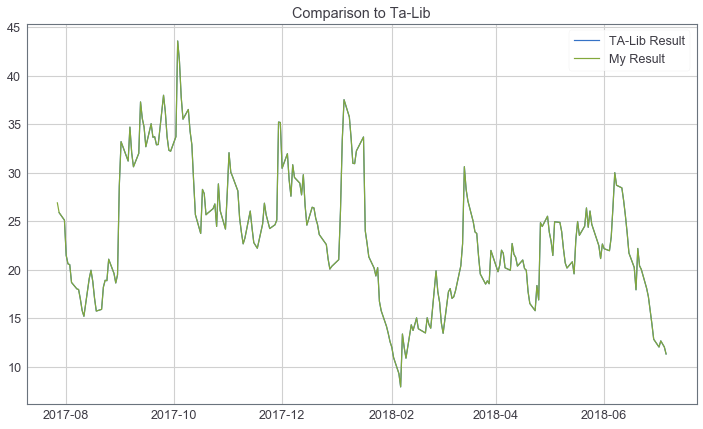

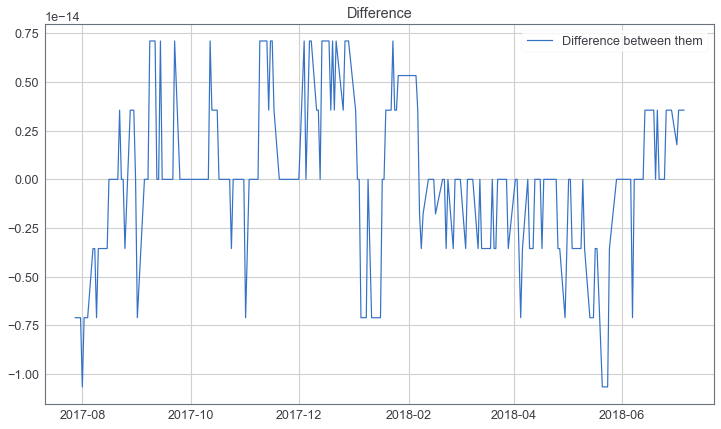

In [187]:
return_index = high.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
plus_di = talib.PLUS_DI(h, l, c,14)
plus_di = pd.Series(plus_di, index=return_index)
perform_test(d[2], plus_di)

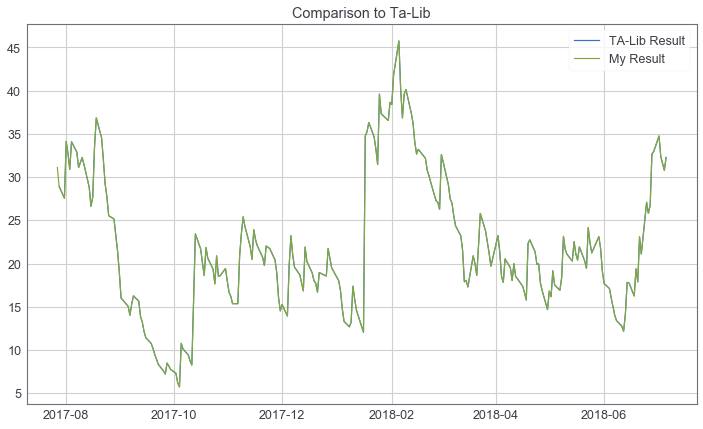

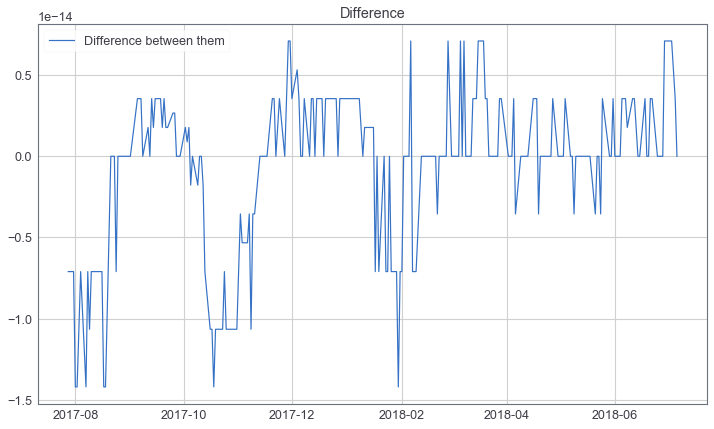

In [188]:
return_index = high.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
minus_di = talib.MINUS_DI(h, l, c,14)
minus_di = pd.Series(minus_di, index=return_index)
perform_test(d[3], minus_di)

### Complete!!

# 지표 설명 : ADX

ADX (Average Directional Movement Index) <br>
평균방향성지표

## 방향성 지표 : DX

### $DX=\frac{(+DI)와\,(-DI)의\, 차이}{(+DI)와\,(-DI)의\, 합계} \,\,\,\,\,\,× 100 $

### Parameters : time_period(기간)=14

In [191]:
a = pd.Series([1,2,3])
b = pd.Series([3,1,2])
abs(a - b)

0    2
1    1
2    1
dtype: int64

In [192]:
def DX(high,low,close,time_period=14):
    d = DMI(high,low,close,time_period)
    plus_di = d[2]
    minus_di = d[3]
    return abs(plus_di - minus_di) / (plus_di + minus_di) * 100

In [194]:
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
dx = talib.DX(h,l,c, 14)
dx = pd.Series(dx, index=return_index)

In [195]:
my_dx = DX(high,low,close,14)

c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


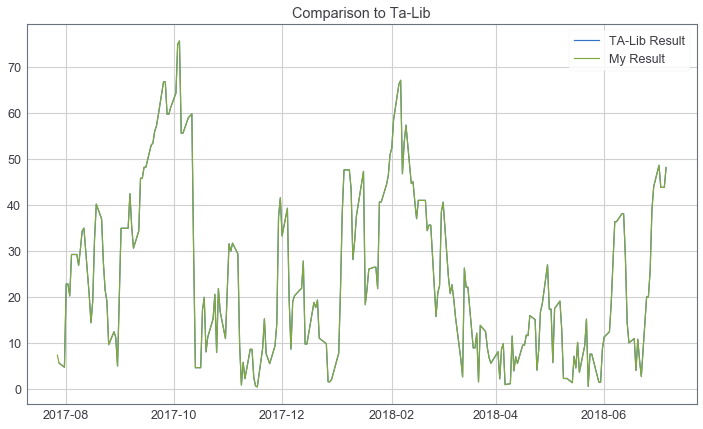

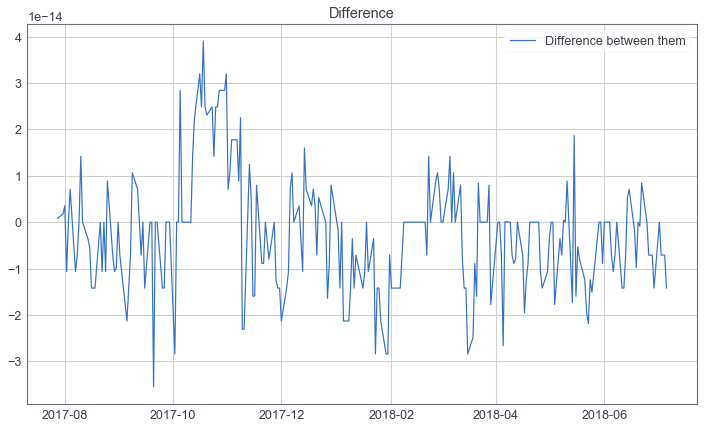

In [196]:
perform_test(my_dx,dx)

## 평균방향성지표 : ADX

+DI, -DI, DX 등과 연관되어 있으며 나아가 한 단계 더 발전된 지표가 ADXR이다. 따라서 ADX만을 따로 떼어서 이용하는 것은 의미가 없다. 관련된 지표들을 총 망라하여 전체적으로 이해해야만 한다.

ADX 는 다음과 같이 산출된다.

### $ADX = \frac{(n-1)×ADX_{-1}+DX}{n}$

### Parameters : time_period(기간)=14

In [228]:
def cum_average(data,period):
    s = pd.Series(index=data.index)
    s.iloc[:period-1] = [np.NaN] * (period-1)
    s.iloc[period-1] = data.iloc[:period].mean()
    for i in range(period,len(data)):
        s[i] = ((period-1) * s[i-1] + data[i]) / period
    return s

In [271]:
def ADX(high,low,close,time_period=14):
    dx = DX(high,low,close,time_period)
    dx = dx.dropna()
    adx = cum_average(dx,time_period)
    return adx

In [272]:
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
adx = talib.ADX(h,l,c, 14)
adx = pd.Series(adx, index=return_index)

In [273]:
my_adx = ADX(high,low,close,14)

c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


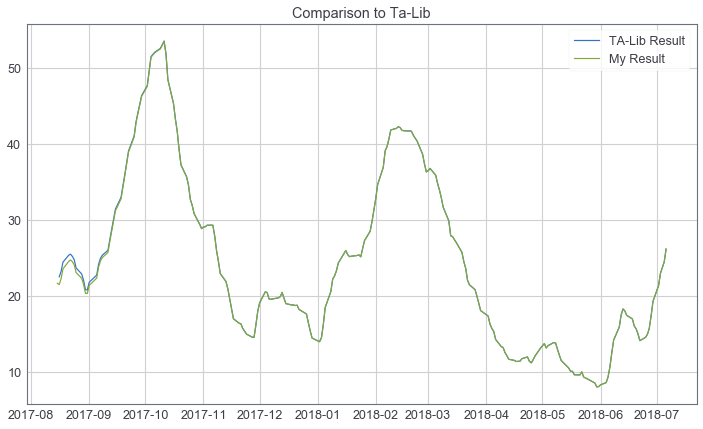

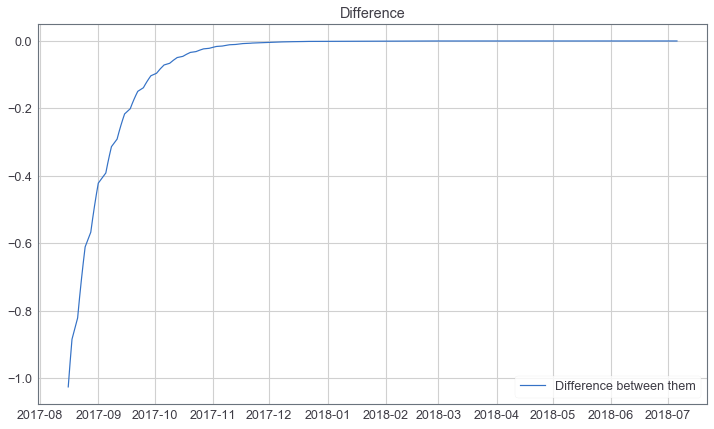

In [274]:
perform_test(my_adx,adx)

## 평균방향성지표 순위 : ADXR

ADXR (Average Directional Movement Rating) <br>
평균방향성지표 순위

ADXR은 당일의 평균 방향성지표(ADX)와 n일전 ADX의 중간값이다. 이 값을 보면 현재의 시장이 추세를 만들면서 움직이는 시장(trending market)인지, 아니면 횡보하는 시장(trading market)인지 파악할 수 있다.

ADXR은 다음과 같이 산출된다.

### $ADXR=\frac{ADX_0+DX_{-n}}{2}$

### Parameters : time_period(기간)=14

In [300]:
def ADXR(high,low,close,time_period=14):
    dx = DX(high,low,close,time_period)
    dx = dx.dropna()
    adx = cum_average(dx,time_period)
    return (adx + adx.shift(time_period-1)) / 2

In [301]:
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
adxr = talib.ADXR(h,l,c, 14)
adxr = pd.Series(adxr, index=return_index)

In [302]:
my_adxr = ADXR(high,low,close,14)

c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\users\wnsvy\anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


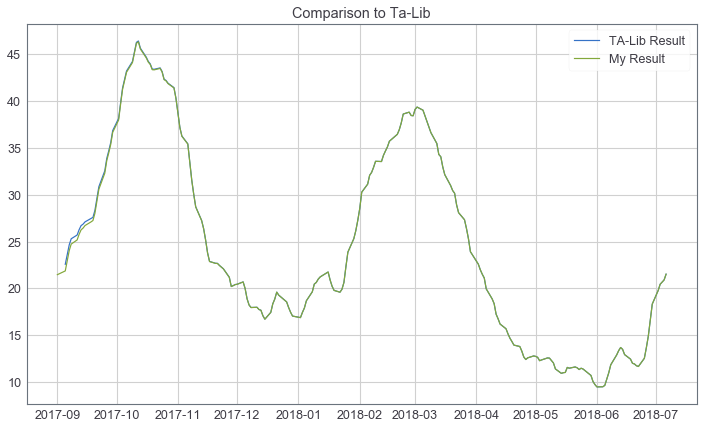

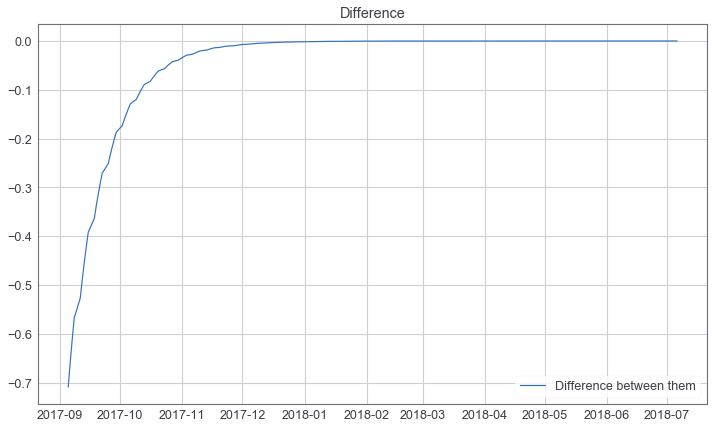

In [303]:
perform_test(my_adxr, adxr)

# 지표설명 : William's %R

William's %R<br>
윌리엄 R퍼센트

스토캐스틱과 유사한 지표이다. 산출하는 방법이 일반적인 기술적지표와는 정반대여서 %R이 바닥에서 상승하면 매도 타이밍이고 %R이 꼭지에서 하락하면 매입 타이밍으로 간주된다. 이 지표는 추세가 정점을 만들거나 바닥을 형성하는 순간을 포착하는 데 효과적이어서 그것만으로도 충분히 존재가치가 있다.

윌리엄 R퍼센트는 다음과 같이 산출된다.

### $\%R = \frac{C-H5}{H5-L5} ×100 = \%K - 100$

C : 오늘의 종가 <br>
L5 : 최근 5일간 최저가 <br>
H5 : 최근 5일간 최고가 <br>

### Parameters : time_period(기간)=5

### 매매방법
- 기준선 매매법
> 80 선을 상향돌파 하는 경우 -> 매수 신호 <br>
> 15 선을 하향돌파 하는 경우 -> 매도 신호
- 시그널 곡선 매매법
> %R의 3일 이동평균선을 산출하여 시그널 곡선으로 사용<br>
%R이 시그널 곡선을 상향돌파 하는 경우 -> 매수 신호<br>
%R이 시그널 곡선을 하향돌파 하는 경우 -> 매도 신호

In [349]:
def WILLR(high, low, close, time_period=5):
    return STOCHF(high,low,close,time_period,3)[0] - 100

In [350]:
my_will_r = WILLR(high,low,close,5)

In [351]:
return_index = close.index
h = np.array(high, dtype='f8')
l = np.array(low, dtype='f8')
c = np.array(close, dtype='f8')
willr = talib.WILLR(h, l, c, 5)
willr = pd.Series(willr, index=return_index)

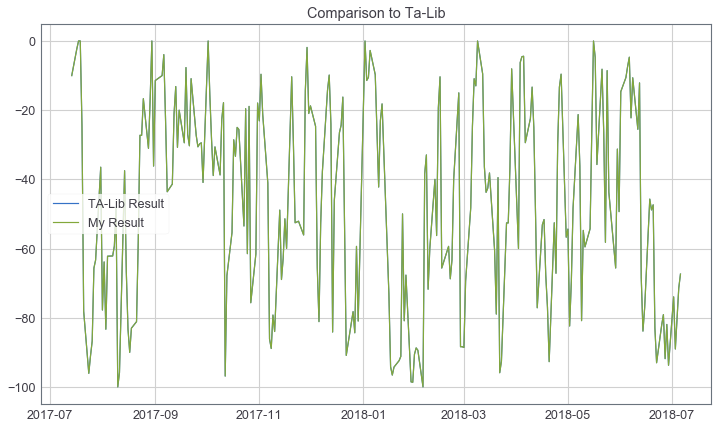

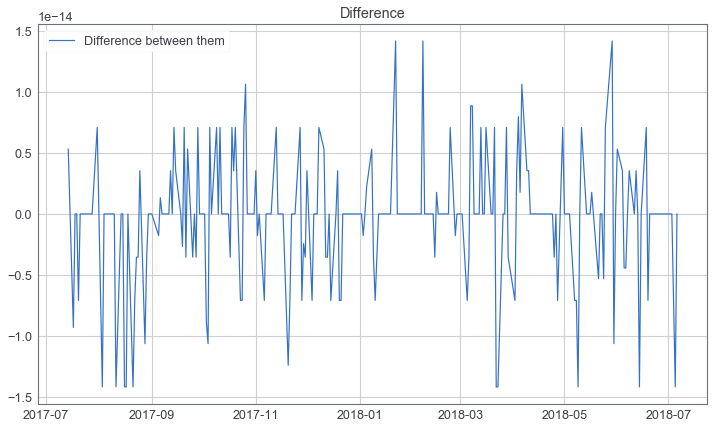

In [352]:
perform_test(my_will_r,willr)

# 지표설명 : 일목균형표 (ta-lib에 없음)

일목균형표는 신문기자 출신의 일본인 일목산인(一目山人)이 개발한 차트 기법이다. 일목균형표라는 이름이 의미하는 것은 시장의 '균형'을 '일목요연'하게 나타내는 '표'라는 뜻이다.

일목균형표는 다음과 같이 산출된다.

### 전환선 = $\frac{H_9+L_9}{2}$
### 기준선 = $\frac{H_{26}+L_{26}}{2}$

$H_9$ : 최근 9일간 최고가격 <br>
$L_9$ : 최근 9일간 최저가격 <br>
$H_{26}$ : 최근 26일간 최고가격 <br>
$L_{26}$ : 최근 26일간 최저가격 

### 선행스팬1 = $\frac{당일의\,기준선값\,+\,당일의\,전환선값}{2}$
### 선행스팬2 = $\frac{최근\,52일간\,최고가격\,+\,최근\,52일간\,최저가격\,}{2}$

*Note : '선행' 이라는 이름이 뜻하듯 차트의 당일자에 이들을 표시하는 것이 아니라, '26일 앞', 즉 선행한 위치에다 선행스팬 1과 선행스팬 2를 각각 나타낸다. 그리고 선행스팬 1과 선행스팬 2 사이에서 만들어지는 공간에 색을 칠하고 이를 '구름'이라고 부른다.

### 후행스팬 = 현재의 가격(종가)을 26일 뒤쪽, 즉 후행하여 표시한 것

### Parameters : 전환=9, 기준=26, 선행1=26, 선행2=52, 후행=26

In [9]:
a = pd.Series([1,2,3])
a.shift(-1)

0    2.0
1    3.0
2    NaN
dtype: float64

In [10]:
def roll_period(high, low, period):
    return (high.rolling(window=period).max() + low.rolling(window=period).min()) / 2   

In [11]:
def ilmok(high,low,close, trans_period=9, base_period=26, preceeding1=26, preceeding2=52, trailing_period = 26):
    trans_line = roll_period(high, low, trans_period)
    base_line = roll_period(high, low, base_period)
    pre_span1 = (trans_line + base_line) / 2
    pre_span1 = pre_span1.shift(preceeding1) # preceeding1 기간 만큼 앞으로 선행
    pre_span2 = roll_period(high, low, preceeding2)
    pre_span2 = pre_span2.shift(preceeding1) # preceeding1 기간 만큼 앞으로 선행
    trailing_span = close.shift(-trailing_period) # 현재 가격을 trailing_period 만큼 뒤로 후행하여 표시
    df = pd.concat([trans_line, base_line, pre_span1, pre_span2, trailing_span],axis=1)
    # 전환선, 기준선, 선행스팬1, 선행스팬2, 후행스팬 이름 지정
    df.columns = ['Trans Line','Base Line','Pre Span1','Pre Span2','Trailing Span']
    return df

In [12]:
ichi_moku = ilmok(high,low,close)

일목균형표의 경우 데이터만 차트에 뿌리면 되는것이 아니라 부분적으로 색칠도 해주어야 함(구름을 만들기 위해) <br>
따라서 charting 할 때 독립적인 모듈을 만들 필요가 있음

In [13]:
x = ichi_moku.index
y1=ichi_moku['Pre Span1']
y2=ichi_moku['Pre Span2']

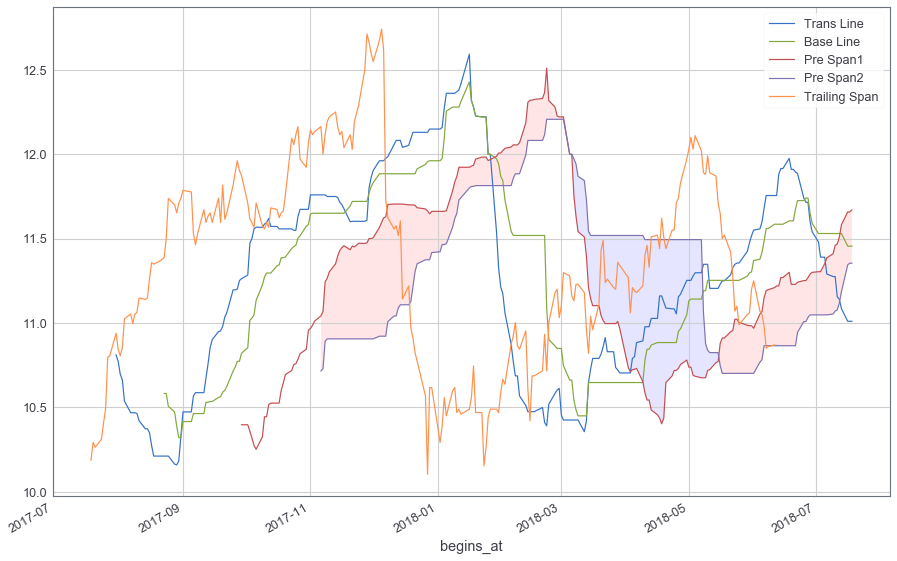

In [14]:
fig = ichi_moku.plot(figsize=(15,10))
fig.fill_between(x, y1, y2, where=y2 >= y1, facecolor='blue', alpha = 0.1, interpolate=True)
fig.fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', alpha = 0.1, interpolate=True)
plt.show()

### 매매 방법

일목균형표는 5개의 선을 이용한 상당히 많은 분석 기법이 존재하는데다, 총 7권의 원서가 존재할 만큼 그 내용이 심오하고 방대하기 때문에 이를 완전히 이해할 수 있는 사람은 매우 드문 것으로 알려져 있다. 따라서 수 많은 분석법 중 가장 일반적으로 많이 쓰이는 방법들을 살표보도록 하겠다.

- **첫 번째 매매 신호**를 포착하는 방법으로는 구름과 캔들과의 관계를 살표보는 것입니다. 일반적으로 캔들이 구름 위에서 생성되면 상승 추세, 반대로 캔들이 구름 밑에서 생겨나면 하락 추세로 알려져 있습니다. 또한, 캔들이 구름을 밑에서 위로 돌파하면 상승 추세로의 전환을 의미하며, 캔들이 위에서 아래로 뚫고 내려가면 하락 추세로의 전환을 의미합니다. 이 외에도 구름의 두께는 저항선의 강도를 나타내기 때문에, 두께가 두꺼울수록 시세의 반전이 나타나기 어렵다고 해석할 수 있습니다.

<center><img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5b5057eb0f2bc4f8b19d7fe6/e80be84e6562d403b6b22e25abd25d0e/image.png"></center>

<center><img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5b5057eb0f2bc4f8b19d7fe6/a5e02d2b9d69bfc66d81caf286cc5e16/image.png"></center>

<center><img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5b5057eb0f2bc4f8b19d7fe6/74e568227a34c760a5ce5fc09dba7a6f/image.png"></center>

<center><img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5b5057eb0f2bc4f8b19d7fe6/468fbcd0c05e91abbc77fa68f55924b7/image.png"></center>

출처 : http://www.nanumtrading.com/fx-배우기/차트-보조지표-이해/06-일목균형표/

# 매물대차트

이 차트는 주가를 새로운 방식으로 나타내는 기법은 아니다. 기존의 캔들차트에다 과거의 거래량을 표시하는 것 뿐이다. 하지만 과거의 거래량을 나타내는 것만으로도 우리에게 훌륭한 정보를 제공한다. 특히 저항선을 파악하는 일에는 유용하다.

*NOTE : 매물대 차트는 산출기간이 달라짐에 따라 들쑥날쑥하게 변화한다. -> 하나의 차트로는 정확한 매물대를 파악할 수 없다는 약점이 있다.*